In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
import utils

#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants

import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm

# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import pandas as pd
import numpy as np
import json
import subprocess

from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from nilearn.image import iter_img,math_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from IPython.display import Image

import nibabel as nib
from nilearn.image import concat_imgs, mean_img
from fsl.wrappers import concatxfm,applyxfm,applyxfm4D
from matplotlib.colors import ListedColormap

In [2]:
RERUN = False

In [3]:
####################
# Setup FSL path
####################
utils.loadFSL()
################
# Start FSLeyes 
################
fsleyesDisplay = utils.FSLeyesServer()
fsleyesDisplay.show()

Gtk-Message: 18:55:46.555: Failed to load module "canberra-gtk-module"
18:55:46: Debug: Adding duplicate image handler for 'Windows bitmap file'
18:55:46: Debug: Adding duplicate animation handler for '1' type
18:55:46: Debug: Adding duplicate animation handler for '2' type
18:55:46: Debug: Adding duplicate image handler for 'Windows bitmap file'
18:55:46: Debug: Adding duplicate animation handler for '1' type
18:55:46: Debug: Adding duplicate animation handler for '2' type

(ipykernel_launcher.py:1177): Gtk-CRITICAL **: 18:55:47.470: gtk_window_resize: assertion 'height > 0' failed


# load and prepare the data

In [4]:
dataset_id= 'ds000171'
subject = 'control01'
subjectID = 'control01'

#path to save
sample_path = "dataset"
bids_root = op.join(sample_path, dataset_id)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

subject_dir = 'sub-{}'.format(subject)

print_dir_tree(bids_root,5)

|ds000171/
|--- CHANGES
|--- README
|--- T1w.json
|--- dataset_description.json
|--- participants.tsv
|--- task-music_bold.json
|--- .ipynb_checkpoints/
|------ T1w-checkpoint.json
|------ dataset_description-checkpoint.json
|------ task-music_bold-checkpoint.json
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ anat/
|--------------- sub-control01_T1w.nii.gz
|--------------- sub-control01_T1w_fast_mixeltype.nii.gz
|--------------- sub-control01_T1w_fast_pve_0.nii.gz
|--------------- sub-control01_T1w_fast_pve_1.nii.gz
|--------------- sub-control01_T1w_fast_pve_2.nii.gz
|--------------- sub-control01_T1w_fast_pveseg.nii.gz
|--------------- sub-control01_T1w_fast_seg.nii.gz
|--------------- sub-control01_T1w_mask.nii.gz
|--------------- sub-control01_T1w_mask_handmodif.nii.gz
|--------------- sub-control01_T1w_mni.mat
|--------------- sub-control01_T1w_mni.nii.gz
|--------------- sub-control01_T1w_mni_SyN.nii.gz
|------------ fmap/
|------------ func

In the precedent part, we have preprocessed the functionnal fmri data. The data is in the functionnal space. 
However, the mask is in the anatomical space. We will put the ICA component in the anatomical space before masking. 

In [5]:
reference = op.expandvars(op.join('$FSLDIR', 'data', 'standard', 'MNI152_T1_1mm_brain.nii.gz'))

# data
data_path = op.join(preproc_root, 'sub-{}'.format(subjectID), 'func', 'sub-{}_all_task_bold_moco.nii.gz'.format(subjectID))
file_path = op.join(preproc_root, 'sub-{}'.format(subjectID), 'func', 'sub-control01_all_task_bold_moco_smoothed-6mm.nii.gz')

# anatomical ref
skull_stripped_t1 = op.join(preproc_root, 'sub-control01', 'anat', 'sub-control01_T1w.nii.gz')

# transformation matrix
func_to_anat_mat = op.join(preproc_root, 'sub-{}'.format(subjectID), 'func', 'sub-{}_all_task_bold_bbr.mat'.format(subjectID))
anat_to_mni_mat = op.join(preproc_root, 'sub-{}'.format(subjectID), 'anat', 'sub-{}_T1w_mni.mat'.format(subjectID))

# mask = grey matter, pve 1
mask_path = op.join(preproc_root, 'sub-control01', 'anat', 'sub-{}_T1w_fast_pve_1.nii.gz'.format(subjectID))

    

In [6]:
fmri_img = nib.load(file_path)
print(fmri_img.shape)

skull_img = nib.load(skull_stripped_t1)
print(skull_img.shape)

(80, 80, 50, 315)
(256, 256, 176)


# ICA

## Apply ICA and get components

In [7]:
# Get affine transform -- check nibabel library for more info!
affine = fmri_img.affine
x = fmri_img.shape[0]
y = fmri_img.shape[1]
z = fmri_img.shape[2]

N_vol= fmri_img.shape[3]
N_subj=1 
N_tot=N_vol*N_subj

# Initialize X
X = np.zeros((N_tot,x*y*z)) # total_timepoints x voxel_num

data_4D = fmri_img.get_fdata() # get the 4D data

# Reshape data to 2D : (timepoints, voxels)
X = data_4D.reshape(-1, N_vol).T

X = zscore(X, axis = 1)
X = np.nan_to_num(X,0) # nan to 0s
print("X matrix size: ", X.shape)

X matrix size:  (315, 320000)


In [10]:
# mask with the grey matter (anatomical space)
binarized_mask = math_img("img > 0.5",img =mask_path)
masker = NiftiMasker(mask_img=binarized_mask)
mean_img_ = mean_img(fmri_img), #data in the functionnal space
output_file = op.join("results","ICAmask")
plot_stat_map(binarized_mask, black_bg=True,bg_img=mean_img_[0], title='the brain mask', colorbar=False,output_file=output_file)

In [15]:
# Run FastICA on X -- check 

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [10,]

#* We will transpose the matrix X so that ICA algorithm operates on the voxels dimension.
#* In other words, the estimated sources (S) should be have dimensionality [#voxels]

for n in nb_components:
    print(f"Processing component {n}")
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    pca = PCA(n_components=n2)
    H = pca.fit_transform(X.T)  # Reconstruct signals based on orthogonal components
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)

    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)

    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary
    print(S_.shape)

    print("Done")

Processing component 10
Running FastICA with n = 10 components
(320000, 10)
(320000, 10)
Done


In [16]:
print("The shape of the estimated Sources is: {}".format(S_.shape))

The shape of the estimated Sources is: (320000, 10)


## plot the components

In [17]:
Result = [] # to save the path of the component and not rerun everything
trs = []
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(8, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
        ##put the component in the anatomical space
        temp_vol_path = f"temp_vol.nii.gz"
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        nib.save(s_img,temp_vol_path)
        applyxfm(src=temp_vol_path,ref=skull_stripped_t1,mat =func_to_anat_mat,out=temp_vol_path)
        img = nib.load(temp_vol_path)
        tr = 2*np.std(s)
        trs.append(tr)
        
        data = masker.fit_transform(img)
        masked_ = masker.inverse_transform(data) # mask the components
        output_plot = op.join("results","ICA_components_{}_n_{}".format(idx,n))
        plot_stat_map(masked_, display_mode="z",cut_coords=[-50,-30,-20,-10,0,10,15,20,25,30,40,50], title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=tr, bg_img=skull_stripped_t1,output_file=output_plot)
        
        output_file= op.join(bids_root, "ICA_components_{}_n_{}".format(idx,n))
        nib.save(masked_,output_file)
        Result.append(output_file)
        plt.show()

Number of components:  10


In [18]:
print(Result)
print(trs)

['dataset/ds000171/ICA_components_0_n_10', 'dataset/ds000171/ICA_components_1_n_10', 'dataset/ds000171/ICA_components_2_n_10', 'dataset/ds000171/ICA_components_3_n_10', 'dataset/ds000171/ICA_components_4_n_10', 'dataset/ds000171/ICA_components_5_n_10', 'dataset/ds000171/ICA_components_6_n_10', 'dataset/ds000171/ICA_components_7_n_10']
[1.9999999999999996, 1.9999999999999998, 2.0, 2.0, 2.0, 1.9999999999999996, 1.9999999999999996, 1.9999999999999998]


In [24]:
# Plot the group-level independent components for the different number of requested components.
for n in nb_components:
    print('Number of components: ',n)
    for i in range(len(Result)): 
        output_plot = op.join("results","ICA_components_{}_n_{}_ortho".format(i,n))
        plot_stat_map(nib.load(Result[i]+'.nii'), display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,i+1),
                      colorbar=True, black_bg=True, threshold=trs[i], bg_img=skull_stripped_t1,output_file=output_plot)
        plt.show()

Number of components:  10


## Result in the MNI space

In [25]:
ResultMNI =[]
for i in range(len(Result)) :
    print("component :",i)
    ica_component_mni = op.join(preproc_root,  'sub-{}'.format(subjectID), 'func', 'sub-{}_icacompoment_{}_mni.nii.gz'.format(subjectID,i))
    ResultMNI.append(ica_component_mni)
    applyxfm(src=Result[i],ref=reference,mat =anat_to_mni_mat,out=ica_component_mni)

component : 0
component : 1
component : 2
component : 3
component : 4
component : 5
component : 6
component : 7


In [26]:
for n in nb_components:
    print('Number of components: ',n)
    for i in range(len(ResultMNI)) :
        output_plot = op.join("results","ICA_componentsMNI_{}_n_{}".format(i,n))
        plot_stat_map(nib.load(ResultMNI[i]), display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,i+1),
                      colorbar=True, black_bg=True, threshold=trs[i],bg_img=reference,output_file=output_plot)
        plt.show()

Number of components:  10


## Visualisation with an atlas

In [22]:
atlas = op.expandvars('$FSLDIR/data/atlases/MNI/MNI-maxprob-thr25-1mm.nii.gz')

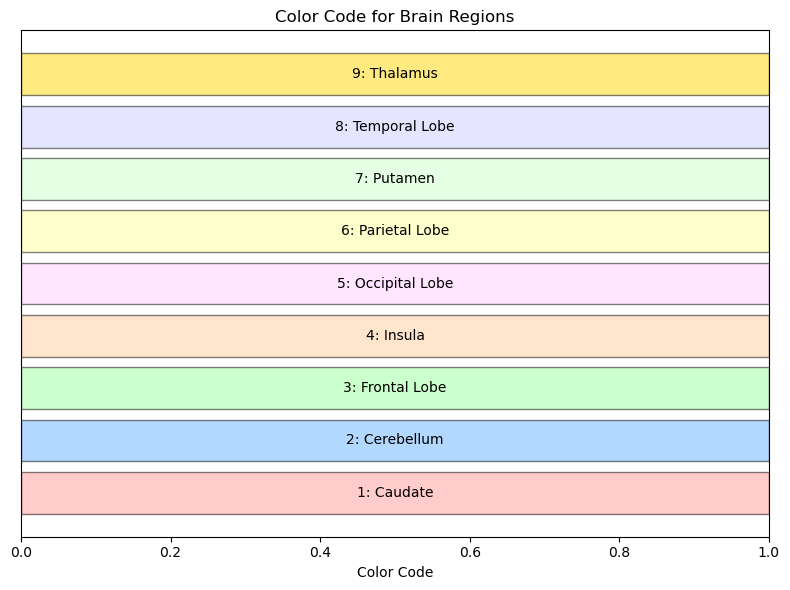

In [29]:
regions = {
    1: ('Caudate', '#FF9999'),      # Light red
    2: ('Cerebellum', '#66B3FF'),   # Light blue
    3: ('Frontal Lobe', '#99FF99'),  # Light green
    4: ('Insula', '#FFCC99'),       # Light orange
    5: ('Occipital Lobe', '#FFCCFF'), # Light pink
    6: ('Parietal Lobe', '#FFFF99'), # Light yellow
    7: ('Putamen', '#CCFFCC'),      # Pale green
    8: ('Temporal Lobe', '#CCCCFF'), # Pale blue
    9: ('Thalamus', '#FFD700')      # Gold
}

def generate_colors(num_colors):
    return plt.cm.viridis(range(num_colors))  # Using the viridis colormap

def create_region_color_mapping(names):
    num_colors = len(names)
    colors = generate_colors(num_colors)
    
    # Convert RGBA to HEX format
    hex_colors = ['#' + ''.join(f'{int(c*255):02x}' for c in color[:3]) for color in colors]
    
    mapping = {}
    for i, (name, color) in enumerate(zip(names, hex_colors)):
        mapping[i + 1] = (name, color)  # Using i + 1 for numbering
    return mapping

# Extract only the colors from the regions dictionary
colors = [color for name, color in regions.values()]

# Create a custom colormap
custom_cmap = ListedColormap(colors)


# Create a figure for the color-region correspondence plot
plt.figure(figsize=(8, 6))
plt.title('Color Code for Brain Regions')

# Create a horizontal bar for each region
for idx, (number, (name, color)) in enumerate(regions.items()):
    plt.barh(idx, 1, color=color, edgecolor='black',alpha = 0.5)
    plt.text(0.5, idx, f'{number}: {name}', ha='center', va='center', fontsize=10, color='black')

# Set the x-axis limits and remove y-ticks
plt.xlim(0, 1)
plt.yticks([])
plt.xlabel('Color Code')
plt.grid(False)
plt.tight_layout()

# Show the plot
plt.savefig(op.join("results","color code ATLAS"))

Number of components:  10


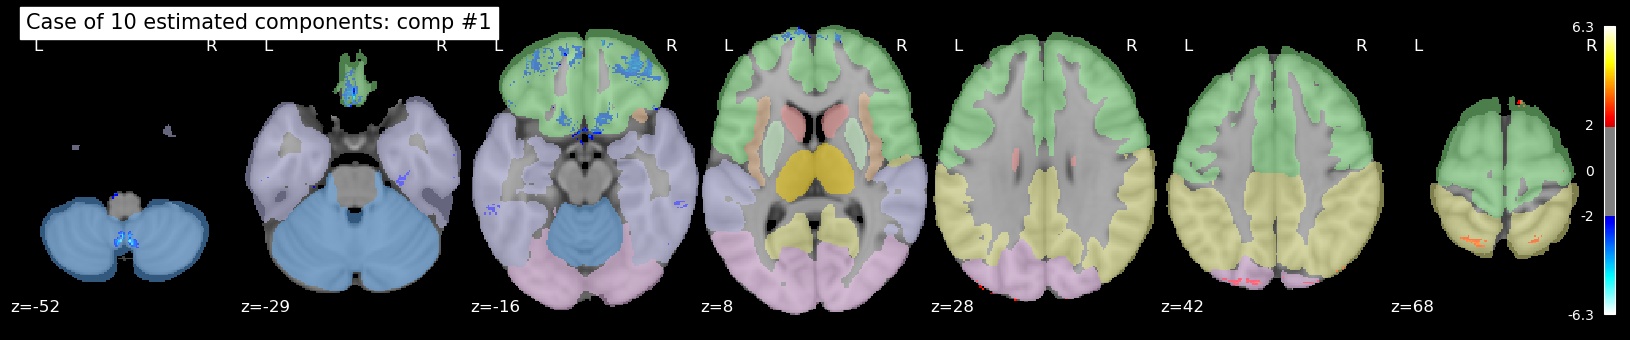

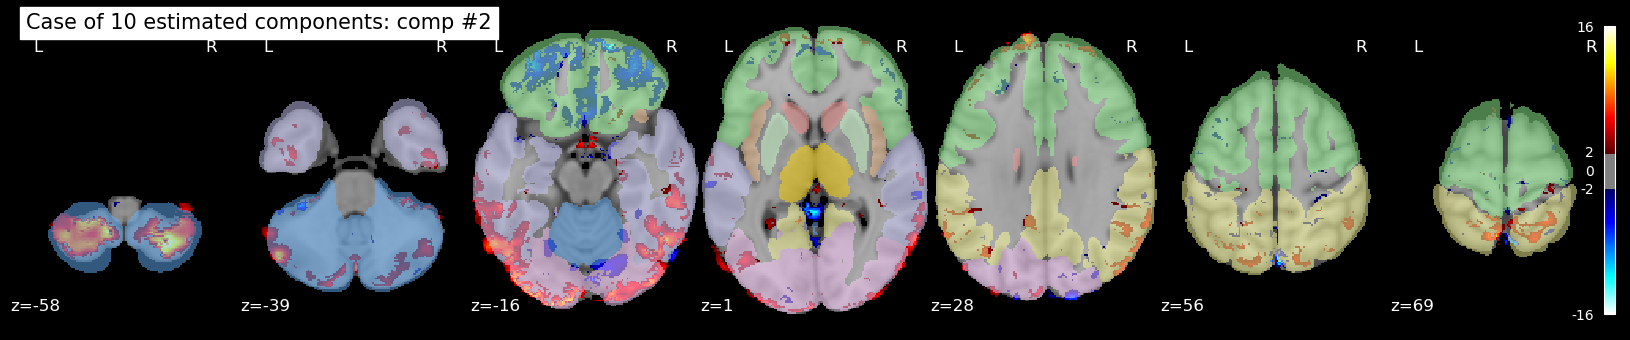

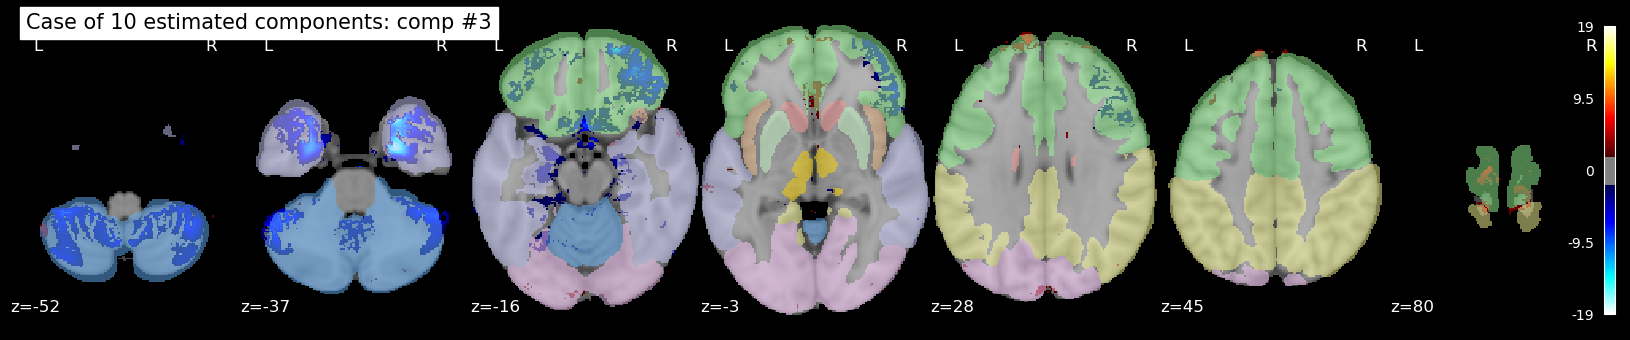

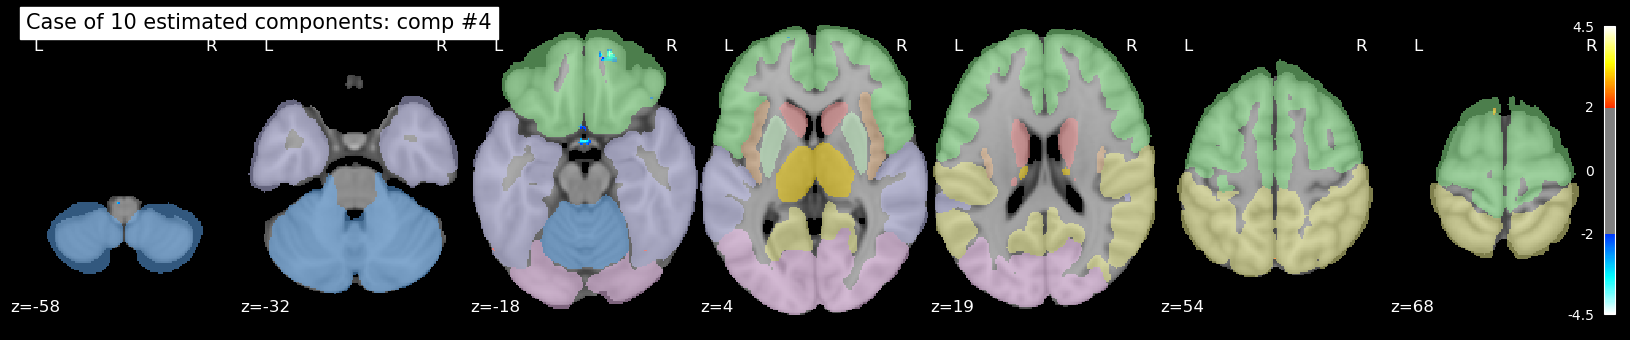

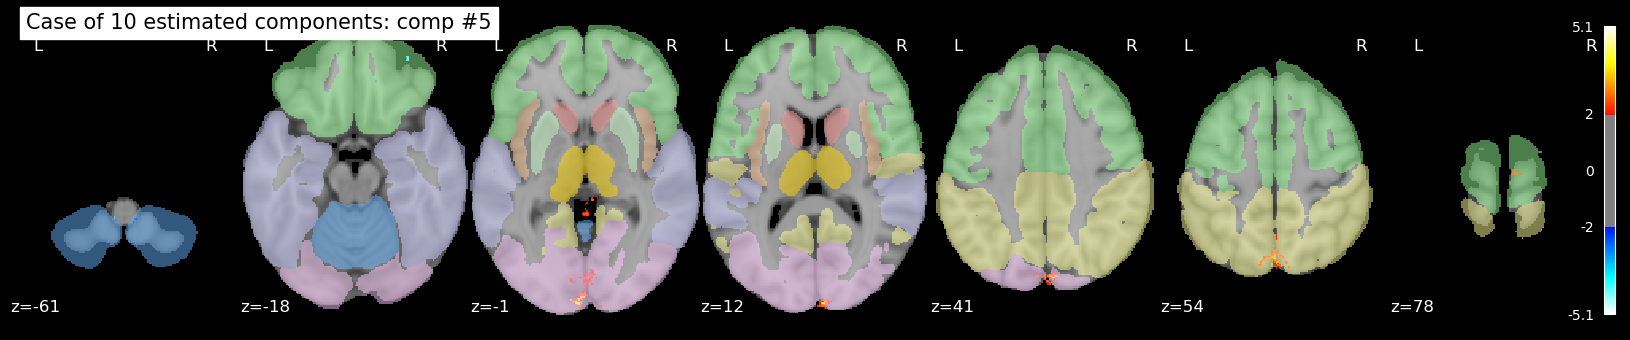

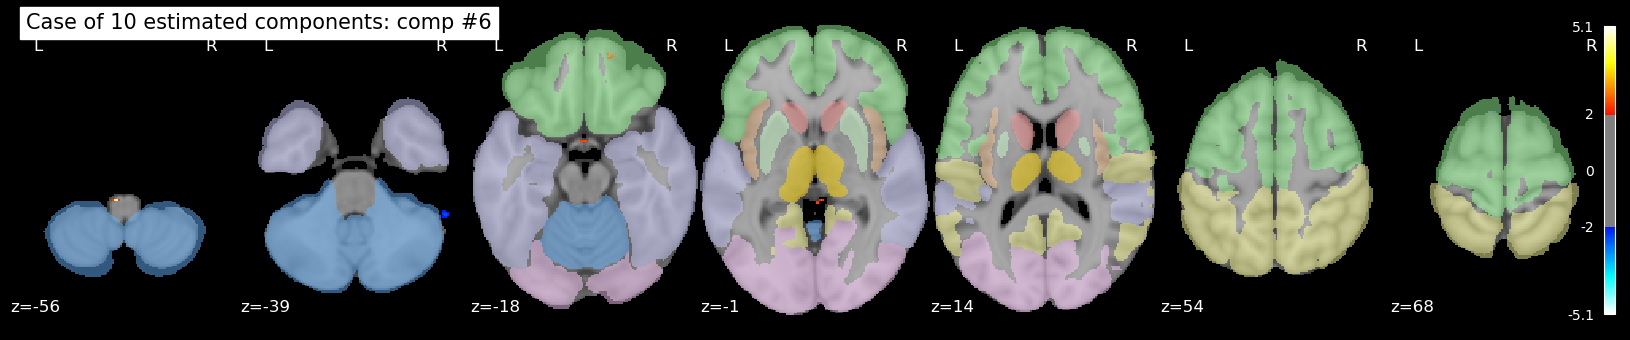

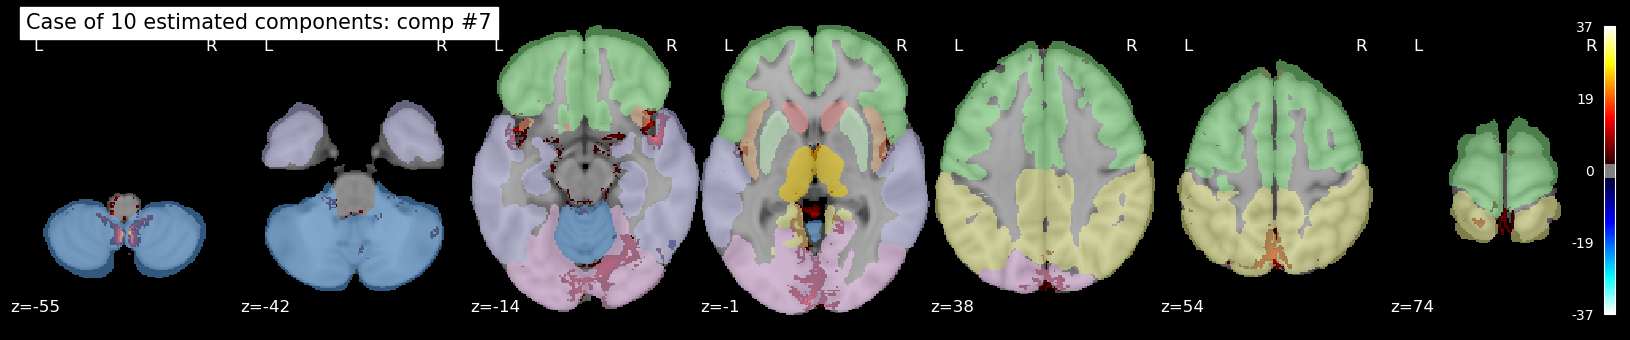

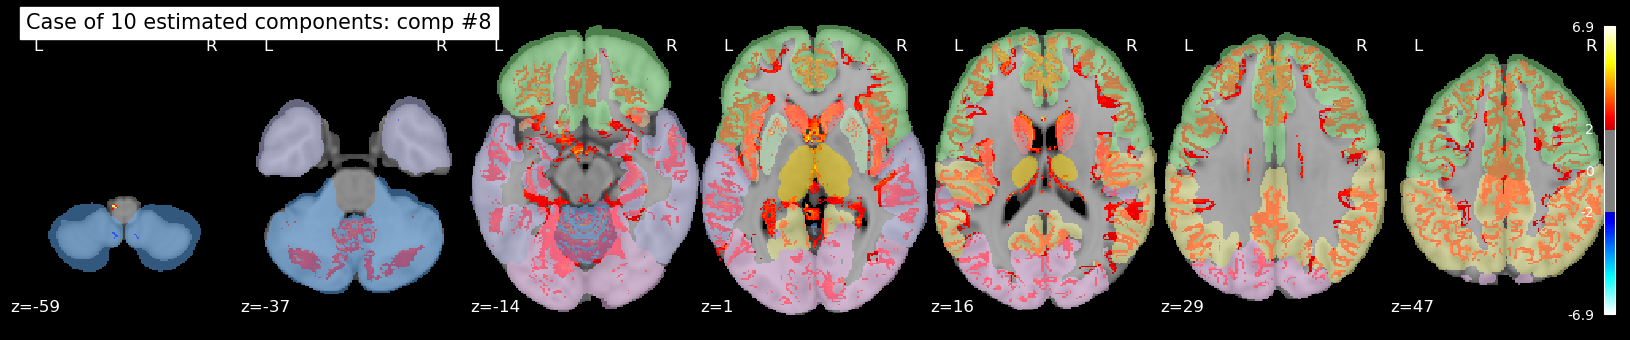

In [31]:
for n in nb_components:
    print('Number of components: ',n)
    for i in range(len(ResultMNI)) :
        output_plot = op.join("results","ICA_componentsMNIATLAS_{}_n_{}".format(i,n))
        mean_atlas = mean_img(atlas),
        stat_map = plot_stat_map(nib.load(ResultMNI[i]), display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,i+1),
                      colorbar=True, black_bg=True, threshold=trs[i],bg_img=reference)
        stat_map.add_overlay(atlas, cmap=custom_cmap,alpha = 0.5)
        plt.savefig(output_plot)

Number of components:  10


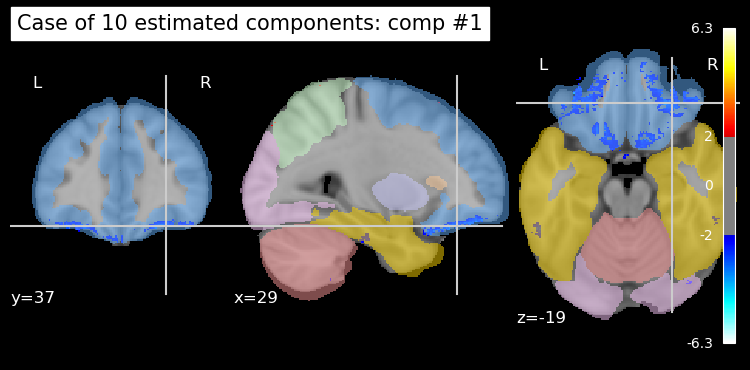

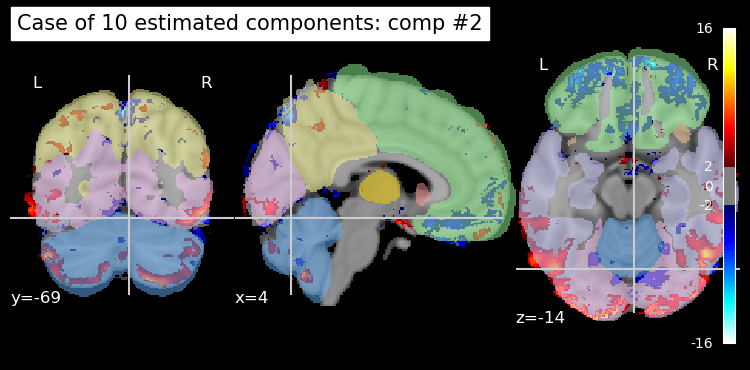

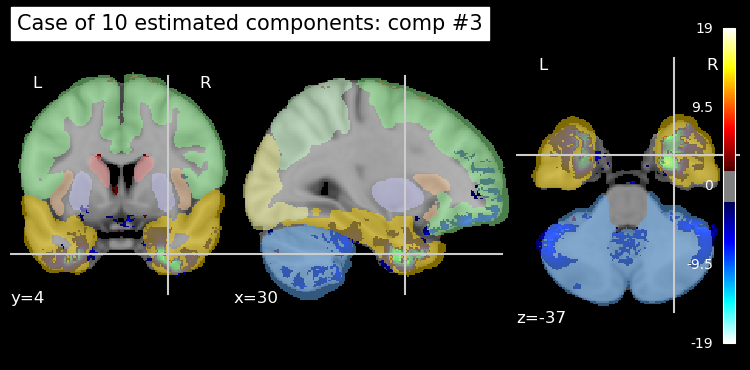

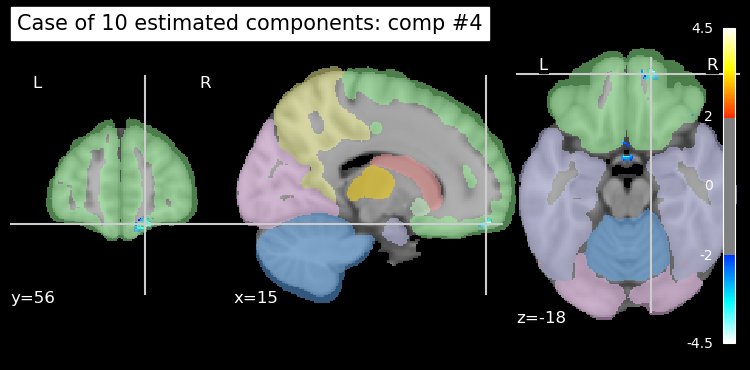

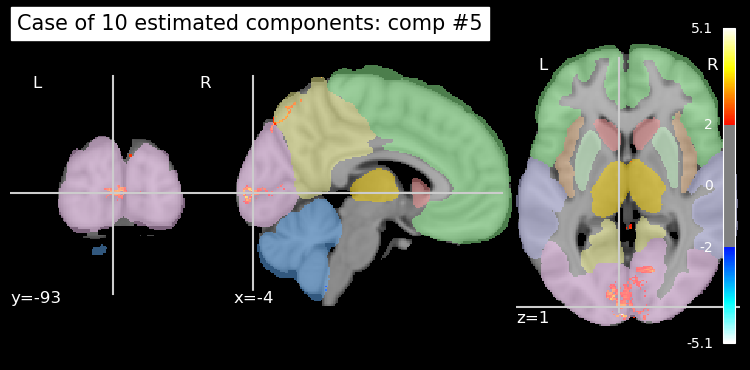

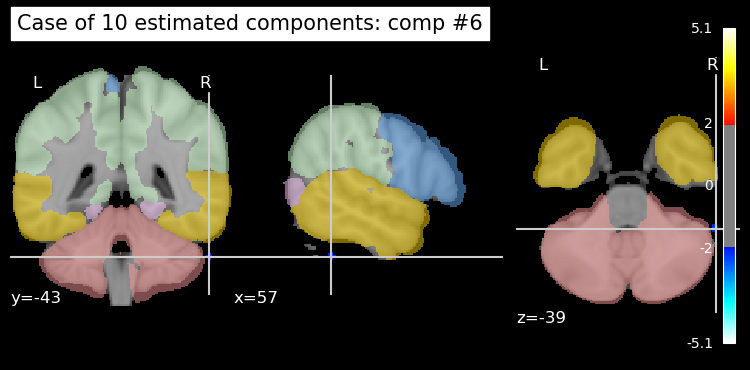

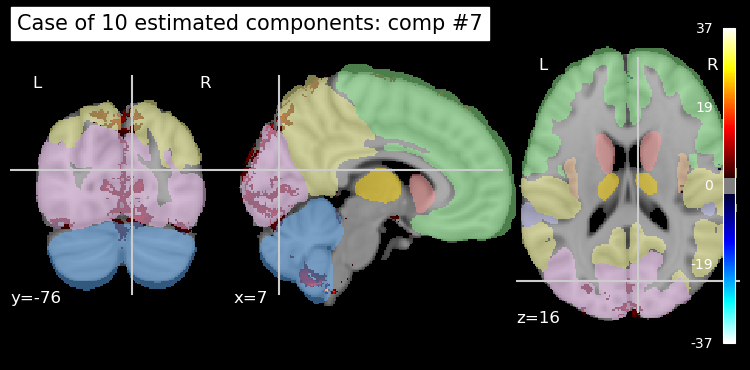

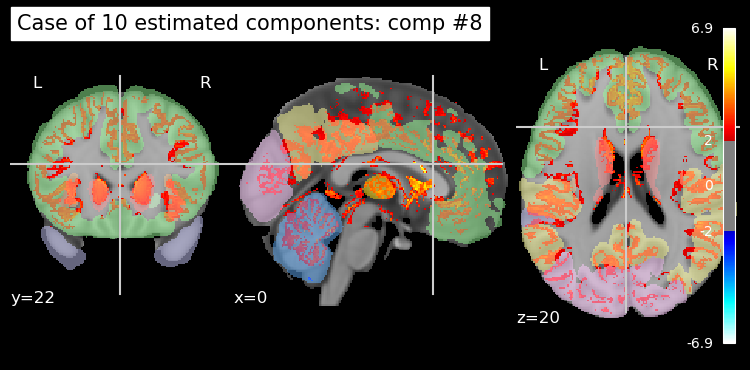

In [32]:
for n in nb_components:
    print('Number of components: ',n)
    for i in range(len(ResultMNI)) :
        output_plot = op.join("results","ICA_componentsMNIATLAS_{}_n_{}_ortho".format(i,n))
        mean_atlas = mean_img(atlas),
        stat_map = plot_stat_map(nib.load(ResultMNI[i]), display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,i+1),
                      colorbar=True, black_bg=True, threshold=trs[i],bg_img=reference)
        stat_map.add_overlay(atlas, cmap=custom_cmap,alpha = 0.5)
        plt.savefig(output_plot)
        plt.show()

In [71]:
aal_atlas = datasets.fetch_atlas_aal()
aal_path = aal_atlas['maps'] 
aal_labels = aal_atlas['labels']
aal_indice = aal_atlas['indices']
aal_dict = {index: label for index, label in zip(aal_indice, aal_labels)}
#display(aal_dict)

In [72]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(reference)
fsleyesDisplay.load(aal_path)
fsleyesDisplay.setOverlayCmap(1,'Render3')
for i in range(len(ResultMNI)) :
    subprocess.run(['fslmaths', ResultMNI[i], '-thr', str(np.round(trs[i],2)), ResultMNI[i]])
    fsleyesDisplay.load(ResultMNI[i])
    fsleyesDisplay.setOverlayCmap(i+2, 'Hot')